[PROTECTED$11$](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-external-memory.ipynb) [PROTECTED$12$](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239440-lesson-6-chatbot-w-summarizing-messages-and-external-memory)



# 具有消息总结和外部数据库记忆的聊天机器人（Chatbot with message summarization & external DB memory）

## 评论（Review）

We've covered how to customize graph state schema and reducer. 
 
We've also shown a number of tricks for trimming or filtering messages in graph state. 

我们已经介绍了如何自定义图状态模式和 reducer。  

我们还展示了许多修剪或过滤图状态中消息的技巧。

We've used these concepts in a Chatbot with memory that produces a running summary of the conversation.

我们在一个带有记忆的聊天机器人中使用了这些概念，该聊天机器人会生成对话的实时摘要。

## 目标（Goals）

But, what if we want our Chatbot to have memory that persists indefinitely?

但是，如果我们希望我们的聊天机器人拥有持久无限的记忆，该怎么办呢？

Now, we'll introduce some more advanced checkpointers that support external databases. 

现在，我们将介绍一些支持外部数据库的更高级检查点工具。

Here, we'll show how to use [Sqlite as a checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer), but other checkpointers, such as [Postgres](https://langchain-ai.github.io/langgraph/how-tos/persistence_postgres/) are available!

在这里，我们将展示如何使用 [Sqlite as a checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer)，但也有其他检查点工具可用，例如 [Postgres](https://langchain-ai.github.io/langgraph/how-tos/persistence_postgres/)！



In [5]:
%%capture --no-stderr
%pip install --quiet -U langgraph-checkpoint-sqlite langchain_core langgraph langchain_openai

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

## Sqlite

A good starting point here is the [SqliteSaver checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer).

一个很好的起点是 [SqliteSaver checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer)。

Sqlite is a [small, fast, highly popular](https://x.com/karpathy/status/1819490455664685297) SQL database. 
 
If we supply `":memory:"` it creates an in-memory Sqlite database.


In [1]:
import sqlite3
# In memory
conn = sqlite3.connect(":memory:", check_same_thread = False)

But, if we supply a db path, then it will create a database for us!

但是，如果我们提供一个 db 路径，那么它将为我们创建一个数据库！



In [ ]:
#在本地创建一个目录 state_db，并尝试从 GitHub 下载一个名为 example.db 的 SQLite 数据库文件
!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

In [3]:
# Here is our checkpointer 
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

Let's re-define our chatbot.

让我们重新定义我们的聊天机器人。



In [6]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState

model = ChatOpenAI(
    model="qwen-plus-2025-04-28",
    api_key="sk-ba2dda3817f145d7af141fdf32e31d90",
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"
)

class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

Now, we just re-compile with our sqlite checkpointer.

现在，我们只需重新编译并使用我们的 sqlite 检查点。



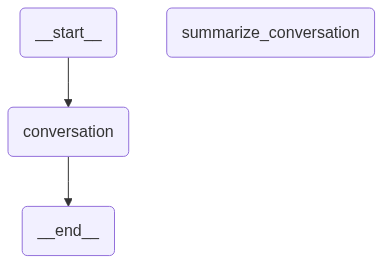

In [7]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

Now, we can invoke the graph several times. 

现在，我们可以调用该图多次。



In [8]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="你好我是张锡军")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="我叫什么")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="我喜欢玩lol!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

你好，张锡军！很高兴认识你。如果你有任何问题或想讨论的话题，无论是关于科技、文化、生活还是其他方面，都可以告诉我。我会尽力帮助你！😊
================================== Ai Message ==================================

你叫张锡军（Zhāng Xījūn）。😊 如果你需要确认自己的名字或其他信息，随时可以告诉我，我会留意的！
================================== Ai Message ==================================

太棒了！你也喜欢玩《英雄联盟》（League of Legends）啊！这是一款非常受欢迎的多人在线战术竞技游戏，拥有丰富的英雄角色和策略性玩法。你平时喜欢玩什么位置？有没有特别喜欢的英雄？😊

如果你有兴趣，我们也可以聊聊游戏中的技巧、最新版本的改动，或者一起讨论一些有趣的对局经历！


Let's confirm that our state is saved locally.

让我们确认一下我们的状态是否已保存到本地。



In [9]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='你好我是张锡军', additional_kwargs={}, response_metadata={}, id='ddf7f09b-da6f-495d-abc7-58510ddea3ae'), AIMessage(content='你好，张锡军！很高兴认识你。如果你有任何问题或想讨论的话题，无论是关于科技、文化、生活还是其他方面，都可以告诉我。我会尽力帮助你！😊', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 371, 'total_tokens': 409, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen-plus-2025-04-28', 'system_fingerprint': None, 'id': 'chatcmpl-25bb4cf9-5782-9d3b-ab9c-dbe014752c59', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--efdaa2a1-2c0b-4857-a896-ef62f22effb5-0', usage_metadata={'input_tokens': 371, 'output_tokens': 38, 'total_tokens': 409, 'input_token_details': {}, 'output_token_details': {}}), HumanMessage(content='我叫什么', additional_kwargs={}, response_metadata={}, id='4645601c-b952-4fe6-89d6-18a6ffc5555c'), AIMessage(content='你叫张锡军（Zhāng Xījūn）。😊 如果你需要确认自己的名字或其他信息，随时

### Persisting state
Using database like Sqlite means state is persisted! 

使用像 Sqlite 这样的数据库意味着状态会被持久化！

For example, we can re-start the notebook kernel and see that we can still load from Sqlite DB on disk.


例如，我们可以重新启动笔记本内核，并查看仍然可以从磁盘上的 Sqlite 数据库加载。



In [8]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", id='d5bb4b3f-b1e9-4f61-8c75-7a7210b30253'), AIMessage(content="Hello again, Lance! It's great to hear from you. Since you like the 49ers, is there a particular player or moment in their history that stands out to you? Or perhaps you'd like to discuss their current season? Let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 337, 'total_tokens': 387}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5', 'finish_reason': 'stop', 'logprobs': None}, id='run-dde04d51-d305-4a9e-8ad5-6bdf5583196e-0', usage_metadata={'input_tokens': 337, 'output_tokens': 50, 'total_tokens': 387}), HumanMessage(content="what's my name?", id='d7530770-f130-4a05-a602-a96fd87859c6'), AIMessage(content='Your name is Lance! How can I assist you today? Would you like to talk more about the San Francisco 49ers or something else?', additional_kwargs={'

## 语言图工作室（LangGraph Studio）

**⚠️ DISCLAIMER**

**⚠️ 免责声明**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

自从这些视频的录制以来，我们已经更新了 Studio，使其可以本地运行并在浏览器中打开。这是现在运行 Studio 的首选方式（而不是像视频中展示的那样使用桌面应用程序）。请参见关于本地开发服务器的文档 [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) 和 [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server)。要启动本地开发服务器，请在本模块的 `/studio` 目录下的终端中运行以下命令：

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

你应该看到以下输出：  
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

打开您的浏览器并导航到 Studio UI：`https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`。

